# Medius AI Task
## Task
Given the titanic dataset (imported from seaborn library) analyze the data and create a model for predicting whether a person survived or not (column alive).
You can add new libraries and additional cells if needed.

The final version of colab needs to execute all cells without any error when ran with `Run all` command.

## Additinal dependency installation and imports
Install any additional dependencies and import them in the cells below.

In [107]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
import scipy.stats
# Imports for data analysis and model construction

## Data exploration and clean up
Explore the data (column types, data distribution, ...) and clean it (handle missing data, invalid data, ...)

First, let's look at the dataset, what features there are and what are their possible values.

In [108]:
df = sns.load_dataset('titanic') # dataset

In [109]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [110]:
df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [111]:
#get unique values of each categorical column and range of each numerical column
#get categorical columns and binary columns
cat_cols = df.select_dtypes(include=['object']).columns
# get unique values of each categorical column
for col in cat_cols:
    print(col, df[col].unique())

sex ['male' 'female']
embarked ['S' 'C' 'Q' nan]
who ['man' 'woman' 'child']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' nan]
alive ['no' 'yes']


In [126]:
#are survived and alive columns the same?
#change no to 0 and yes to 1
df['alive'] = df['alive'].replace('no', 0).replace('yes', 1)
(df['survived'] == df['alive']).all()

/tmp/ipykernel_100049/2006734140.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['alive'] = df['alive'].replace('no', 0).replace('yes', 1)


True

In [138]:
df['class'] = df['class'].replace('First', 1).replace('Second', 2).replace('Third', 3)
(df['pclass'] == df['class']).all()

#class and pclass are the same!

/tmp/ipykernel_100049/1930385774.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['class'] = df['class'].replace('First', 1).replace('Second', 2).replace('Third', 3)
/tmp/ipykernel_100049/1930385774.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['class'] = df['class'].replace('First', 1).replace('Second', 2).replace('Third', 3)
/tmp/ipykernel_100049/1930385774.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that p

True

In [145]:
#get max value of age in df[~a]
df[~a]['age'].max()
#child is up to 15 years old 

#--> age + sex is enough (childer only up to 15 years old)

15.0

In [139]:
df['embarked'] = df['embarked'].replace('C', 'Cherbourg').replace('Q', 'Queenstown').replace('S', 'Southampton')
b = (df['embarked'] == df['embark_town'])

In [131]:
df[~b]

#embarked and embark_town are the same!

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
61,1,1,female,38.0,0,0,80.0,NaN,1,woman,False,B,NaN,1,True
829,1,1,female,62.0,0,0,80.0,NaN,1,woman,False,B,NaN,1,True


In [140]:
#check if 0 in parch and in sibsp means true in alone
(df['alone'] == ((df['parch'] == 0) & (df['sibsp'] == 0))).all()

#alone is redundant feature

True

We can see there are some duplicated and some redundant columns in the dataset. 

Identicall features:
- embarked & embark_town
- survived & alive
- pclass & class

Redundant features:
- alone: if columns sibsp (number of siblings and spouses travelling with the passenger) and parch (number of children and parents with the passenger) are both 0, the value in alone column will be Ture, and False otherwise. 
- adult male: will be False for children and women, this information is also included in column who, which has possible values woman, man, child.

Let's look at how features influence survival.

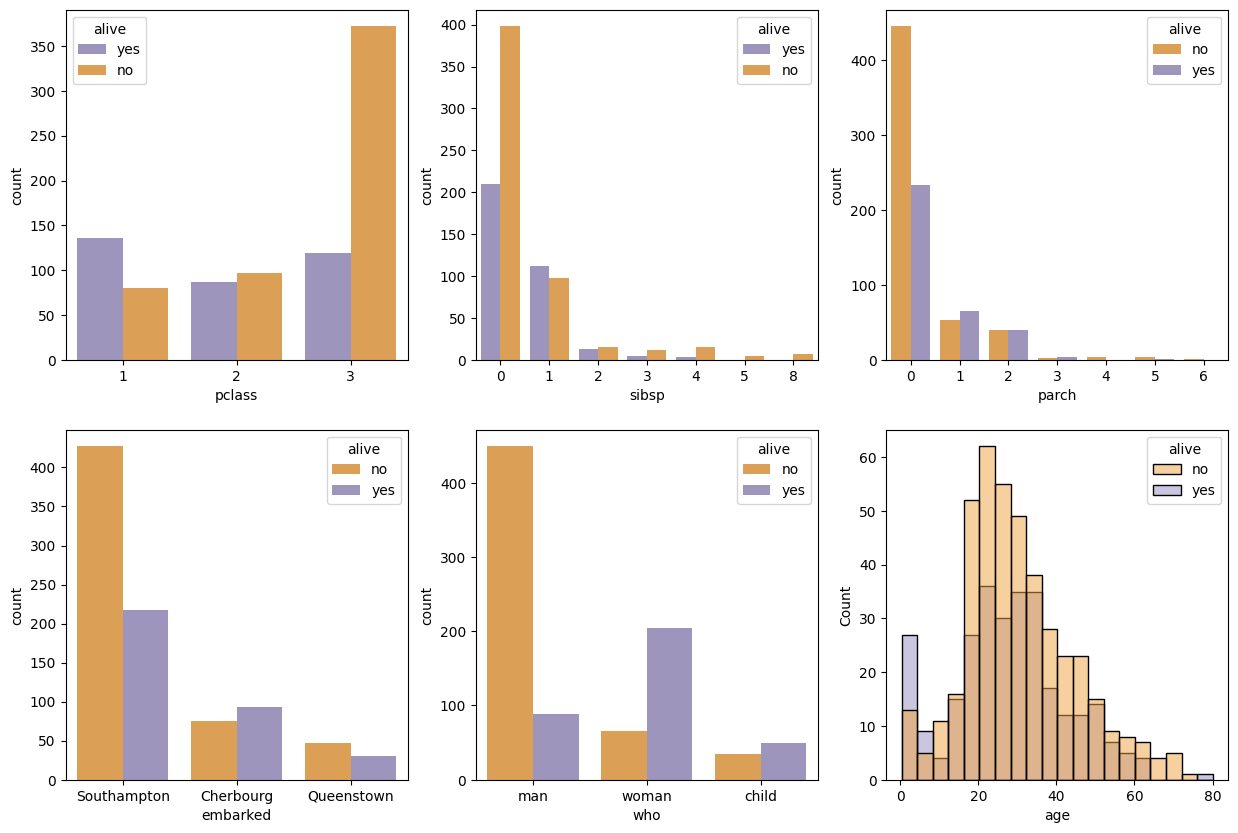

In [144]:
#plots of features in relation to survived
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# The color palette
colors = {'no': '#f1a340', 'yes': '#998ec3'}


sns.countplot(x='pclass', hue='alive', data=df, ax=axs[0, 0], palette=colors)
sns.countplot(x='sibsp', hue='alive', data=df, ax=axs[0, 1], palette=colors)
sns.countplot(x='parch', hue='alive', data=df, ax=axs[0, 2], palette=colors)
sns.countplot(x='embarked', hue='alive', data=df, ax=axs[1, 0], palette=colors)
sns.countplot(x='who', hue='alive', data=df, ax=axs[1, 1], palette=colors)
sns.histplot(x='age', hue='alive', data=df, ax=axs[1, 2], palette=colors)
#sns.histplot(x='fare', hue='alive', data=df, ax=axs[2, 0], palette=colors)
plt.savefig('countplots.png')


plt.show()



<Axes: xlabel='fare', ylabel='Count'>

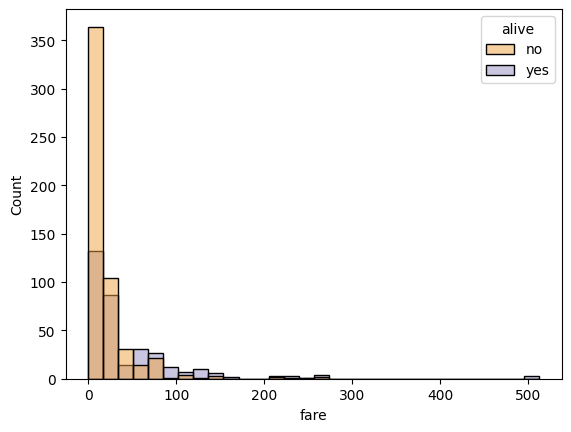

In [172]:
sns.histplot(x='fare', hue='alive', data=df, palette=colors, bins=30)

At the first glance our expectation is that sex and wether the passenger is a child have a lot of influence on the survival. Additionally, The class the passenger was travelling in also visibly influences the survival. We can see the fare has some influence on  the survival as well but it is also correlated to passenger class so it makes sense.

#### Missing values and duplicated rows:

In [175]:
duplicated_rows = df[df.duplicated()]
unique_duplicated_rows = duplicated_rows.drop_duplicates()

# Display the unique duplicated rows
print(unique_duplicated_rows)

     survived  pclass     sex    age  sibsp  parch     fare     embarked  \
47          1       3  female    NaN      0      0   7.7500   Queenstown   
76          0       3    male    NaN      0      0   7.8958  Southampton   
77          0       3    male    NaN      0      0   8.0500  Southampton   
133         1       2  female  29.00      1      0  26.0000  Southampton   
173         0       3    male  21.00      0      0   7.9250  Southampton   
196         0       3    male    NaN      0      0   7.7500   Queenstown   
201         0       3    male    NaN      8      2  69.5500  Southampton   
213         0       2    male  30.00      0      0  13.0000  Southampton   
241         1       3  female    NaN      1      0  15.5000   Queenstown   
295         0       1    male    NaN      0      0  27.7208    Cherbourg   
313         0       3    male  28.00      0      0   7.8958  Southampton   
320         0       3    male  22.00      0      0   7.2500  Southampton   
343         

In [176]:
len(duplicated_rows)

107

In [174]:
print(f"percentage of rows with nan values: {unique_duplicated_rows.isna().sum() / len(unique_duplicated_rows)}")

percentage of rows with nan values: survived       0.000000
pclass         0.000000
sex            0.000000
age            0.415094
sibsp          0.000000
parch          0.000000
fare           0.000000
embarked       0.000000
class          0.000000
who            0.000000
adult_male     0.000000
deck           0.981132
embark_town    0.000000
alive          0.000000
alone          0.000000
dtype: float64


There are 107 duplicated rows. When further inspecting the duplicated rows we see that 41.5 % of duplicated rows has missing age column and 98.1 % duplicated rows have missing deck column. If these values would be available there would probably not be so many duplicated rows. 

In [6]:
#check for missing values
df.isnull().sum()/len(df)

survived       0.000000
pclass         0.000000
sex            0.000000
age            0.198653
sibsp          0.000000
parch          0.000000
fare           0.000000
embarked       0.002245
class          0.000000
who            0.000000
adult_male     0.000000
deck           0.772166
embark_town    0.002245
alive          0.000000
alone          0.000000
dtype: float64

There are missing values in columns age (19.87%), embarked (0.22%), embark_town (0.22%), and deck (77.22%). There is so little missing values in embarked and embark_town that they can be ignored. To decide what to do with the missing values in columns age and deck we have to further inspect them.

Text(0.5, 1.0, 'Missing Data')

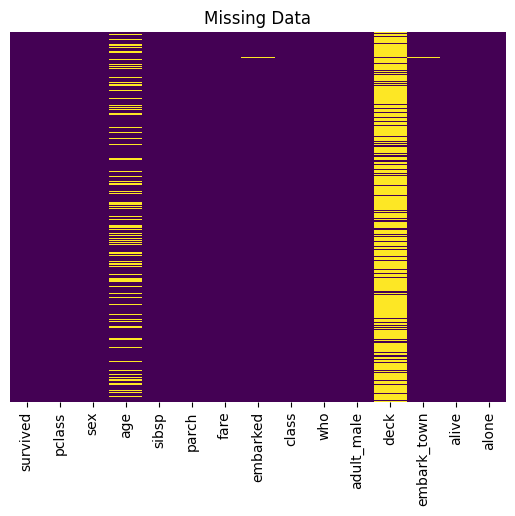

In [9]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing Data')

We can't really see any pattern regarding the missing values with the heatmap.

Since our target variable is survival status of the passenger let's look at the distribution of missing values for deck column in regard to survival.

<Axes: xlabel='deck', ylabel='count'>

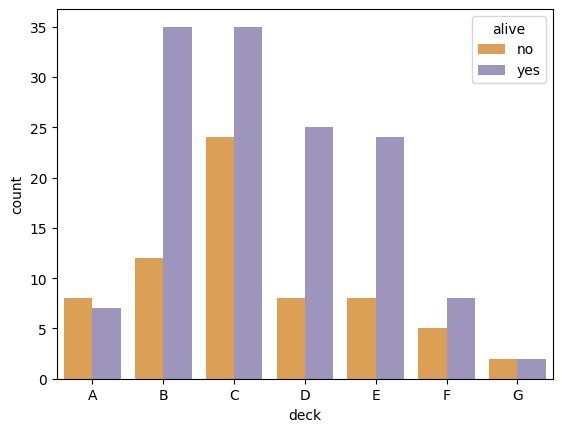

In [199]:
#plot deck vs survived
sns.countplot(x='deck', hue='alive', data=df, palette=colors)

/tmp/ipykernel_100049/1660410676.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='alive', data=deck_nan, palette=custom_palette, stat='percent')
/tmp/ipykernel_100049/1660410676.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='alive', data=df, palette=custom_palette, stat='percent')


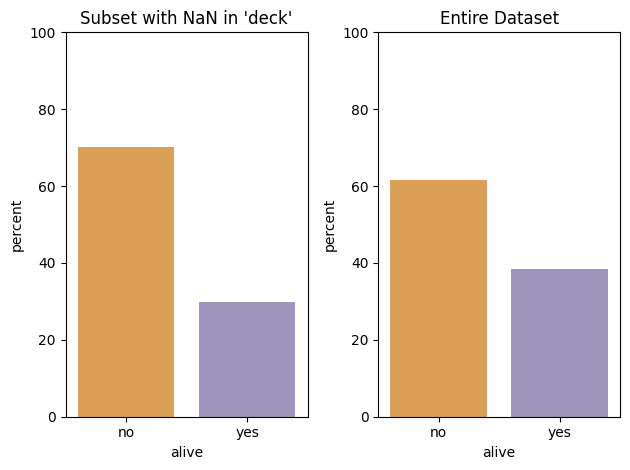

Counts of survived and not survived with NaN in 'deck':
alive
no     482
yes    206
Name: count, dtype: int64

Counts of survived and not survived in entire dataset:
alive
no     549
yes    342
Name: count, dtype: int64


In [195]:
# Get rows with NaN in 'deck'
deck_nan = df[df['deck'].isnull()]


custom_palette = {'yes': '#998ec3', 'no': '#f1a340'}

# Countplot for 'alive' in subset with NaN in 'deck'
plt.subplot(1, 2, 1)
sns.countplot(x='alive', data=deck_nan, palette=custom_palette, stat='percent')
plt.ylim(0, 100)  
plt.title("Subset with NaN in 'deck'")

# Countplot for 'alive' in entire dataset
plt.subplot(1, 2, 2)
sns.countplot(x='alive', data=df, palette=custom_palette, stat='percent')
plt.ylim(0, 100)  
plt.title("Entire Dataset")

plt.tight_layout()
plt.show()

print("Counts of survived and not survived with NaN in 'deck':")
print(deck_nan['alive'].value_counts())

print("\nCounts of survived and not survived in entire dataset:")
print(df['alive'].value_counts())


We can see that the rows where deck values are not nan are more frequent for surviving passengers. Class and deck might be correlated features as each class might be located on a speciffic deck.

In [20]:
#change column deck to factor
df["deck"] = df["deck"].astype('category')


In [46]:
#change all non numerical columns to factor
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

missing values in column 'deck' per passenger class: pclass
1     41
2    168
3    479
Name: deck, dtype: int64


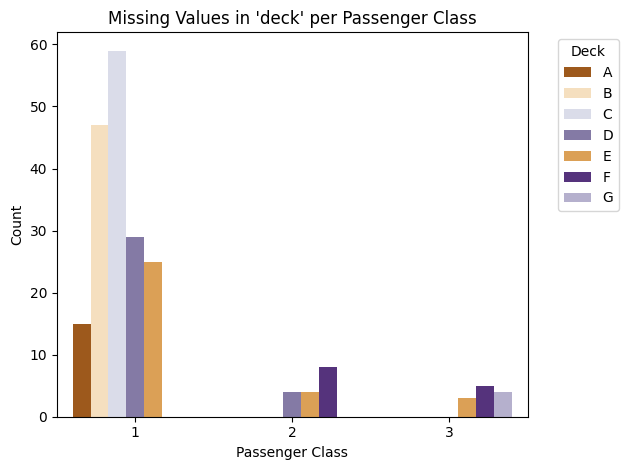

In [219]:

colors = ['#b35806',  '#fee0b6', '#d8daeb', '#8073ac', '#f1a340', '#542788', '#b2abd2']

# Count missing values in column 'deck' per class in column 'pclass'
cn_class = df.groupby('pclass')['deck'].apply(lambda x: x.isnull().sum())
print(f"missing values in column 'deck' per passenger class: {cn_class}")

# Plot missing values in column 'deck' per class in column 'pclass' bar plot
sns.countplot(x='pclass', data=df, hue='deck', palette=colors)
plt.title("Missing Values in 'deck' per Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("Count")
plt.legend(title='Deck', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


Values in column deck are present mostly for the first class passengers. These values still bring some information so we will not discard them.  

In [47]:
#one hot encode categorical variables
df_dummies = pd.get_dummies(df, drop_first=True)

In [50]:
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


/tmp/ipykernel_100049/2008080416.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='alive', data=age_nan, palette=custom_palette, stat='percent')
/tmp/ipykernel_100049/2008080416.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='alive', data=df, palette=custom_palette, stat='percent')


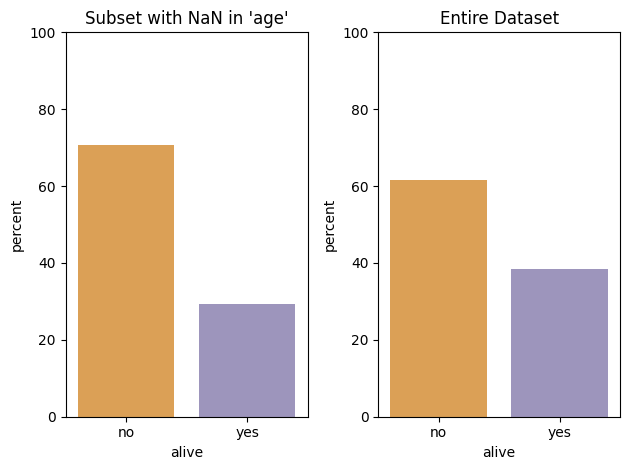

Counts of survived and not survived with NaN in 'age':
alive
no     125
yes     52
Name: count, dtype: int64

Counts of survived and not survived in entire dataset:
alive
no     549
yes    342
Name: count, dtype: int64


In [203]:
age_nan = df[df['age'].isnull()]


custom_palette = {'yes': '#998ec3', 'no': '#f1a340'}

# Countplot for 'alive' in subset with NaN in 'age'
plt.subplot(1, 2, 1)
sns.countplot(x='alive', data=age_nan, palette=custom_palette, stat='percent')
plt.ylim(0, 100)  
plt.title("Subset with NaN in 'age'")

# Countplot for 'alive' in entire dataset
plt.subplot(1, 2, 2)
sns.countplot(x='alive', data=df, palette=custom_palette, stat='percent')
plt.ylim(0, 100)  
plt.title("Entire Dataset")

plt.tight_layout()
plt.show()

print("Counts of survived and not survived with NaN in 'age':")
print(age_nan['alive'].value_counts())

print("\nCounts of survived and not survived in entire dataset:")
print(df['alive'].value_counts())


Column 'who', can help us approximate the missing values of age, as it tells us if the passenger is an adult or child. It will not be precise but this information might help the model.

/tmp/ipykernel_100049/2010062204.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='who', data=age_nan, palette=custom_palette, stat='percent')
/tmp/ipykernel_100049/2010062204.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='who', data=df, palette=custom_palette, stat='percent')


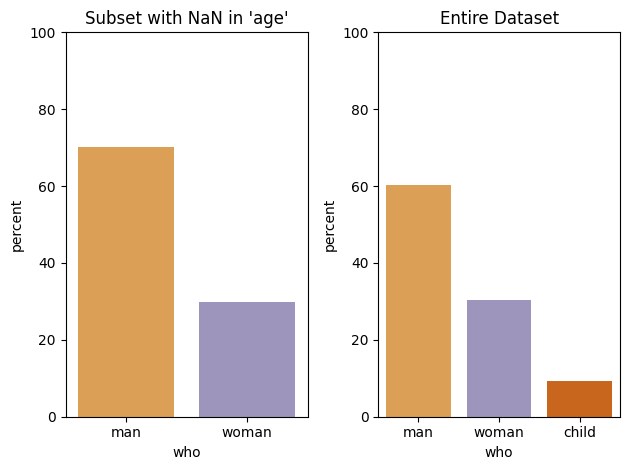

Counts of survived and not survived with NaN in 'age':
who
man      124
woman     53
Name: count, dtype: int64


In [206]:

# Get rows with NaN in 'age'
age_nan = df[df['age'].isnull()]


custom_palette = {'woman': '#998ec3', 'man': '#f1a340', 'child' : '#e66101'}

plt.subplot(1, 2, 1)
sns.countplot(x='who', data=age_nan, palette=custom_palette, stat='percent')
plt.ylim(0, 100)  
plt.title("Subset with NaN in 'age'")

# Countplot for 'alive' in entire dataset
plt.subplot(1, 2, 2)
sns.countplot(x='who', data=df, palette=custom_palette, stat='percent')
plt.ylim(0, 100)  
plt.title("Entire Dataset")

plt.tight_layout()
plt.show()

print("Counts of survived and not survived with NaN in 'age':")
print(age_nan['who'].value_counts())


The plot shows there are no missing values in age for children. In the dataset passengers are treated as children up to including 15 years old. With this information it will be easier to infer the missing age values.

<Axes: xlabel='age', ylabel='Count'>

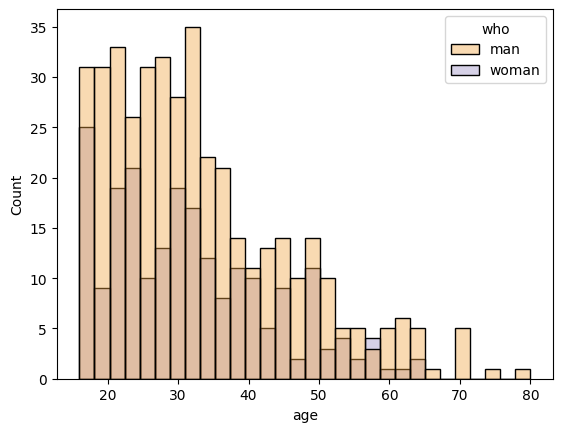

In [212]:
#check age distribution for woman and man in who column (no children)
sns.histplot(x='age', hue='who', data=df[df['who'] != 'child'], palette=custom_palette, bins=30, alpha = 0.4)

#### Cleanup of duplicated and redundant features

Discarding duplicated columns embarked, alive, class. Dis

Discarding redundant columns alone and adult male. 

In [5]:
#delete columns ['embarked, 'alive', 'class', 'alone', 'adult_male']
df = df.drop(columns=['embarked', 'alive', 'class', 'alone', 'adult_male'])
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,who,deck,embark_town
0,0,3,male,22.0,1,0,7.2500,man,NaN,Southampton
1,1,1,female,38.0,1,0,71.2833,woman,C,Cherbourg
2,1,3,female,26.0,0,0,7.9250,woman,NaN,Southampton
3,1,1,female,35.0,1,0,53.1000,woman,C,Southampton
4,0,3,male,35.0,0,0,8.0500,man,NaN,Southampton


## Data preparation


#### Dealing with missing values

Categorical features need to be turned into dummy features. Even if 77% values in column deck are missing, dummy variables will enable using information about it where it is available, which can benefit the model. For this reason the column will not be dropped.

There are no missing values of age for children. We can estimate age values for women and men using mean age for each sex seperately. 

There are two missing values for embark_town feature. This is not signifficant and if there is some information to why these two values are missing dummy variables will retain it. 

In [6]:
#get mean age for each who category
mean_age = df.groupby('who')['age'].mean()
print(mean_age)

who
child     6.369518
man      33.173123
woman    32.000000
Name: age, dtype: float64


In [7]:
#fill missing values in age column with mean age for each who category
df['age'] = df['age'].fillna(df.groupby('who')['age'].transform('mean'))
df.isna().sum()

survived         0
pclass           0
sex              0
age              0
sibsp            0
parch            0
fare             0
who              0
deck           688
embark_town      2
dtype: int64

In [8]:
#get mean age for each who category
mean_age = df.groupby('who')['age'].mean()
print(mean_age)

who
child     6.369518
man      33.173123
woman    32.000000
Name: age, dtype: float64


In [9]:
#check duplicate rows
duplicated_rows = df[df.duplicated()]
unique_duplicated_rows = duplicated_rows.drop_duplicates()
len(unique_duplicated_rows)

53

In [10]:
#remove duplicate rows
df = df.drop_duplicates()
df.shape

(784, 10)

Categorical features need to be transformed into dummy variables. 

In [11]:
df_dummies = pd.get_dummies(df, drop_first=True)
df_dummies.head()

,survived,pclass,age,sibsp,parch,fare,sex_male,who_man,who_woman,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,embark_town_Queenstown,embark_town_Southampton
0,0,3,22.0,1,0,7.2500,True,True,False,False,False,False,False,False,False,False,True
1,1,1,38.0,1,0,71.2833,False,False,True,False,True,False,False,False,False,False,False
2,1,3,26.0,0,0,7.9250,False,False,True,False,False,False,False,False,False,False,True
3,1,1,35.0,1,0,53.1000,False,False,True,False,True,False,False,False,False,False,True
4,0,3,35.0,0,0,8.0500,True,True,False,False,False,False,False,False,False,False,True


In [12]:
df_dummies.isna().sum()

survived                   0
pclass                     0
age                        0
sibsp                      0
parch                      0
fare                       0
sex_male                   0
who_man                    0
who_woman                  0
deck_B                     0
deck_C                     0
deck_D                     0
deck_E                     0
deck_F                     0
deck_G                     0
embark_town_Queenstown     0
embark_town_Southampton    0
dtype: int64

We have out dummy variables and there is no missing values or duplicated rows. We can train the model now.

## Model training
Train and evaluate multiple models and find the one that predicts livenss the best.


- my nn implementation
- boosted trees - xgboost
- log reg
- majority baseline?
- SVM

#### Gradient boosted trees

In [13]:
#use xgboost to build gradient boosted trees
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
#import logloss for cross validation
from sklearn.metrics import log_loss
import tqdm
#import wandb
#from 
# .integration.xgboost import WandbCallback
import logging

X = df_dummies.drop(columns='survived')
y = df_dummies['survived']


In [16]:
#wandb.login()


True

In [17]:
#force reload of wandb
#wandb.login(relogin=True)


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /home/anjah/.netrc


True

In [83]:
#cross validation function
def cross_validate(X, y, model, n_splits=5, reps = 1):
    scores_CA = []
    scores_logloss = []

    #split the data into n_splits
    for rep in range(reps):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rep+1)
        ca_rep = []
        logloss_rep = []
        with tqdm.tqdm(total=n_splits) as pbar:
            for train_index, test_index in skf.split(X, y):

                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                #model.fit(X_train, y_train, callbacks=[WandbCallback()])
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                ca_rep.append(np.mean(accuracy_score(y_test, y_pred)))
                y_pred_proba = model.predict_proba(X_test)
                logloss_rep.append(np.mean(log_loss(y_test, y_pred_proba)))

                pbar.update(1)
            
        print(f"CA rep: {np.mean(ca_rep)}")
        print(f"logloss rep: {np.mean(logloss_rep)}")
        scores_CA.append(np.mean(ca_rep))
        scores_logloss.append(np.mean(logloss_rep))


    #wandb.finish()

    return scores_CA, scores_logloss



In [84]:
btrees_model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, colsample_bytree=0.2)

In [85]:
#cross validation 10 time 5 fold
#logging.basicConfig(level=logging.DEBUG)
#initialize wandb!

scores_CA, scores_logloss = cross_validate(X, y, btrees_model, n_splits=5, reps = 10)

100%|██████████| 5/5 [00:00<00:00, 17.00it/s]


CA rep: 0.8035440143720398
logloss rep: 0.46140709703427457


100%|██████████| 5/5 [00:00<00:00, 22.15it/s]


CA rep: 0.7908704883227177
logloss rep: 0.46390125033378987


100%|██████████| 5/5 [00:00<00:00,  9.32it/s]


CA rep: 0.8022619630899885
logloss rep: 0.4548750201662119


100%|██████████| 5/5 [00:00<00:00, 20.05it/s]


CA rep: 0.7984484729707659
logloss rep: 0.45513098676357283


100%|██████████| 5/5 [00:00<00:00, 21.54it/s]


CA rep: 0.7907643312101911
logloss rep: 0.45937247695773636


100%|██████████| 5/5 [00:00<00:00, 21.27it/s]


CA rep: 0.7933937612281561
logloss rep: 0.45486350130305475


100%|██████████| 5/5 [00:00<00:00, 20.02it/s]


CA rep: 0.7972644128695084
logloss rep: 0.46053385990338525


100%|██████████| 5/5 [00:00<00:00, 20.56it/s]


CA rep: 0.7947248081006042
logloss rep: 0.4577543978758364


100%|██████████| 5/5 [00:00<00:00, 21.83it/s]


CA rep: 0.7983994773803691
logloss rep: 0.4550502896558946


100%|██████████| 5/5 [00:00<00:00, 21.52it/s]

CA rep: 0.8009962436714029
logloss rep: 0.447678993730147


In [29]:
#end wandb run
#wandb.finish()

In [86]:
#get the mean and standard error of the mean of the scores
mean_CA = np.mean(scores_CA)
sem_CA = scipy.stats.sem(scores_CA)
mean_logloss = np.mean(scores_logloss)
sem_logloss = scipy.stats.sem(scores_logloss)

print(f"Mean accuracy: {mean_CA}, SEM accuracy: {sem_CA}")
print(f"Mean logloss: {mean_logloss}, SEM logloss: {sem_logloss}")

Mean accuracy: 0.7970667973215744, SEM accuracy: 0.0014344963664758904
Mean logloss: 0.45705678737239036, SEM logloss: 0.0014489818112188367


Results of Boosted trees classifer:
- Mean accuracy: 0.7970667973215744, SEM accuracy: 0.0014344963664758904
- Mean logloss: 0.45705678737239036, SEM logloss: 0.0014489818112188367

#### Logistic Regression

In [88]:
from sklearn.preprocessing import StandardScaler

In [89]:
#cross validation function
def cross_validate_LR(X, y, model, n_splits=5, reps = 1):
    scores_CA = []
    scores_logloss = []
    coefs = []

    #split the data into n_splits
    for rep in range(reps):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rep+1)
        ca_rep = []
        logloss_rep = []
        coefs_rep = []
        with tqdm.tqdm(total=n_splits) as pbar:
            for train_index, test_index in skf.split(X, y):

                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                #model.fit(X_train, y_train, callbacks=[WandbCallback()])
                # scale the data
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                ca_rep.append(np.mean(accuracy_score(y_test, y_pred)))
                y_pred_proba = model.predict_proba(X_test)
                logloss_rep.append(np.mean(log_loss(y_test, y_pred_proba)))
                coefs_rep.append(model.coef_)
                pbar.update(1)
            
        print(f"CA rep: {np.mean(ca_rep)}")
        print(f"logloss rep: {np.mean(logloss_rep)}")
        scores_CA.append(np.mean(ca_rep))
        scores_logloss.append(np.mean(logloss_rep))
        coefs.append(np.mean(coefs_rep, axis=0))
    

    #wandb.finish()

    return scores_CA, scores_logloss, coefs


In [45]:
a = [1,2,3,4,5]
a[0] = np.mean(a[1:])
a[1:] = []
a

[3.5]

In [47]:
#logistic regression model
from sklearn.linear_model import LogisticRegression 
log_reg = LogisticRegression(max_iter=1000, fit_intercept=False)

In [90]:
scores_CA_lr, scores_logloss_lr, coefs_lr = cross_validate_LR(X, y, log_reg, n_splits=5, reps = 10)

100%|██████████| 5/5 [00:00<00:00, 41.80it/s]


CA rep: 0.7908214927323207
logloss rep: 0.4783634168530685


100%|██████████| 5/5 [00:00<00:00, 38.17it/s]


CA rep: 0.7857912787849093
logloss rep: 0.4730785224817848


100%|██████████| 5/5 [00:00<00:00, 50.08it/s]


CA rep: 0.7831373509717459
logloss rep: 0.4758293362159967


100%|██████████| 5/5 [00:00<00:00, 17.91it/s]


CA rep: 0.7856524579454517
logloss rep: 0.4730901335154786


100%|██████████| 5/5 [00:00<00:00, 20.18it/s]


CA rep: 0.7805242528172466
logloss rep: 0.480809059782767


100%|██████████| 5/5 [00:00<00:00, 35.40it/s]


CA rep: 0.7844765637759268
logloss rep: 0.47603841013593734


100%|██████████| 5/5 [00:00<00:00, 43.33it/s]


CA rep: 0.787065164135228
logloss rep: 0.47513152152189875


100%|██████████| 5/5 [00:00<00:00, 45.24it/s]


CA rep: 0.78192879307529
logloss rep: 0.4763460934828102


100%|██████████| 5/5 [00:00<00:00, 30.71it/s]


CA rep: 0.7869263432957702
logloss rep: 0.4721352755068148


100%|██████████| 5/5 [00:00<00:00, 45.27it/s]

CA rep: 0.7907724971419239
logloss rep: 0.46876970805120644


In [91]:
scores_logloss_lr

[0.4783634168530685,
 0.4730785224817848,
 0.4758293362159967,
 0.4730901335154786,
 0.480809059782767,
 0.47603841013593734,
 0.47513152152189875,
 0.4763460934828102,
 0.4721352755068148,
 0.46876970805120644]

In [92]:
mean_CA_lr = np.mean(scores_CA_lr)
sem_CA_lr = scipy.stats.sem(scores_CA_lr)
mean_logloss_lr = np.mean(scores_logloss_lr)
sem_logloss_lr = scipy.stats.sem(scores_logloss_lr)
print(f"Mean accuracy: {mean_CA_lr}, SEM accuracy: {sem_CA_lr}")
print(f"Mean logloss: {mean_logloss_lr}, SEM logloss: {sem_logloss_lr}")

Mean accuracy: 0.7857096194675812, SEM accuracy: 0.001077092276993636
Mean logloss: 0.47495914775477627, SEM logloss: 0.0010697833072553515


In [93]:
coefs = np.mean(coefs_lr, axis=0)
coef_sem = scipy.stats.sem(coefs_lr, axis=0)
coefs = coefs.flatten()
coefs = pd.Series(coefs, index=X.columns)
coefs

pclass                    -0.663650
age                       -0.363860
sibsp                     -0.449655
parch                     -0.223097
fare                       0.200789
sex_male                  -0.112954
who_man                   -1.196280
who_woman                  0.167324
deck_B                     0.132321
deck_C                     0.000964
deck_D                     0.224975
deck_E                     0.276182
deck_F                     0.121322
deck_G                    -0.043884
embark_town_Queenstown    -0.143058
embark_town_Southampton   -0.190651
dtype: float64

In [94]:
coef_sem

array([[0.00091063, 0.00098477, 0.00094299, 0.00122325, 0.00242812,
        0.00165598, 0.00172393, 0.00182038, 0.00140371, 0.00069901,
        0.00148706, 0.00086833, 0.00201528, 0.00033933, 0.00071699,
        0.00069695]])

Results for Logistic regression:
- Mean accuracy: 0.7857096194675812, SEM accuracy: 0.001077092276993636
- Mean logloss: 0.47495914775477627, SEM logloss: 0.0010697833072553515

#### SVM

In [97]:
#cross validation function
def cross_validate_SVM(X, y, model, n_splits=5, reps = 1):
    scores_CA = []
    scores_logloss = []
    #coefs = []

    #split the data into n_splits
    for rep in range(reps):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rep+1)
        ca_rep = []
        logloss_rep = []
        coefs_rep = []
        with tqdm.tqdm(total=n_splits) as pbar:
            for train_index, test_index in skf.split(X, y):

                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                #model.fit(X_train, y_train, callbacks=[WandbCallback()])
                # scale the data
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                ca_rep.append(np.mean(accuracy_score(y_test, y_pred)))
                y_pred_proba = model.predict_proba(X_test)
                logloss_rep.append(np.mean(log_loss(y_test, y_pred_proba)))
                #coefs_rep.append(model.coef_)
                pbar.update(1)
            
        print(f"CA rep: {np.mean(ca_rep)}")
        print(f"logloss rep: {np.mean(logloss_rep)}")
        scores_CA.append(np.mean(ca_rep))
        scores_logloss.append(np.mean(logloss_rep))
        #coefs.append(np.mean(coefs_rep, axis=0))
    

    #wandb.finish()

    return scores_CA, scores_logloss


In [96]:
#SVM for classification
from sklearn.svm import SVC
svm = SVC(probability=True)

In [98]:
CA_SVM, logloss_SVM = cross_validate_SVM(X, y, svm, n_splits=5, reps = 10)

100%|██████████| 5/5 [00:00<00:00, 23.40it/s]


CA rep: 0.7972235832108444
logloss rep: 0.47009157944860025


100%|██████████| 5/5 [00:00<00:00, 25.54it/s]


CA rep: 0.8061897762534705
logloss rep: 0.46656904377461206


100%|██████████| 5/5 [00:00<00:00, 25.50it/s]


CA rep: 0.7907969949371223
logloss rep: 0.4775184486782564


100%|██████████| 5/5 [00:00<00:00, 24.92it/s]


CA rep: 0.7984484729707659
logloss rep: 0.4733424134864184


100%|██████████| 5/5 [00:00<00:00, 25.52it/s]


CA rep: 0.7945778213294137
logloss rep: 0.47829564403579095


100%|██████████| 5/5 [00:00<00:00, 25.19it/s]


CA rep: 0.794651314715009
logloss rep: 0.4696452727322418


100%|██████████| 5/5 [00:00<00:00, 25.06it/s]


CA rep: 0.806206108116936
logloss rep: 0.4707754836650471


100%|██████████| 5/5 [00:00<00:00, 16.23it/s]


CA rep: 0.8049077249714193
logloss rep: 0.4699541783676347


100%|██████████| 5/5 [00:00<00:00, 24.67it/s]


CA rep: 0.7996815286624204
logloss rep: 0.4685336962013283


100%|██████████| 5/5 [00:00<00:00, 25.29it/s]

CA rep: 0.8086232239098482
logloss rep: 0.4615819177039369


In [99]:
mean_CA_SVM = np.mean(CA_SVM)
sem_CA_SVM = scipy.stats.sem(CA_SVM)
mean_logloss_SVM = np.mean(logloss_SVM)
sem_logloss_SVM = scipy.stats.sem(logloss_SVM)
print(f"Mean accuracy: {mean_CA_SVM}, SEM accuracy: {sem_CA_SVM}")
print(f"Mean logloss: {mean_logloss_SVM}, SEM logloss: {sem_logloss_SVM}")

Mean accuracy: 0.800130654907725, SEM accuracy: 0.0019091157472501718
Mean logloss: 0.47063076780938673, SEM logloss: 0.0015565672269352434


Results for SVM:
- Mean accuracy: 0.800130654907725, SEM accuracy: 0.0019091157472501718
- Mean logloss: 0.47063076780938673, SEM logloss: 0.0015565672269352434

#### Majority classifier Baseline

In [103]:
#count positive and negative samples
1 -y.mean()

0.5880102040816326

In [104]:
#cross validate majority class classifier
def cross_validate_majority(X, y, n_splits=5, reps = 1):
    scores_CA = []
    scores_logloss = []

    #split the data into n_splits
    for rep in range(reps):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rep+1)
        ca_rep = []
        logloss_rep = []
        with tqdm.tqdm(total=n_splits) as pbar:
            for train_index, test_index in skf.split(X, y):

                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                #model.fit(X_train, y_train, callbacks=[WandbCallback()])
                # scale the data
                #scaler = StandardScaler()
                #X_train = scaler.fit_transform(X_train)
                #X_test = scaler.transform(X_test)
                y_pred = np.zeros(len(y_test))
                ca_rep.append(np.mean(accuracy_score(y_test, y_pred)))
                logloss_rep.append(np.mean(log_loss(y_test, y_pred)))
                pbar.update(1)
            
        print(f"CA rep: {np.mean(ca_rep)}")
        print(f"logloss rep: {np.mean(logloss_rep)}")
        scores_CA.append(np.mean(ca_rep))
        scores_logloss.append(np.mean(logloss_rep))
    

    #wandb.finish()

    return scores_CA, scores_logloss

In [105]:
CA_majority, logloss_majority = cross_validate_majority(X, y, n_splits=5, reps = 10)

100%|██████████| 5/5 [00:00<00:00, 357.21it/s]


CA rep: 0.5880124122162338
logloss rep: 14.849537814696543


100%|██████████| 5/5 [00:00<00:00, 345.81it/s]


CA rep: 0.5880124122162338
logloss rep: 14.849537814696543


100%|██████████| 5/5 [00:00<00:00, 345.51it/s]


CA rep: 0.5880124122162338
logloss rep: 14.849537814696543


100%|██████████| 5/5 [00:00<00:00, 290.68it/s]


CA rep: 0.5880124122162338
logloss rep: 14.849537814696543


100%|██████████| 5/5 [00:00<00:00, 212.00it/s]


CA rep: 0.5880124122162338
logloss rep: 14.849537814696543


100%|██████████| 5/5 [00:00<00:00, 190.43it/s]


CA rep: 0.5880124122162338
logloss rep: 14.849537814696543


100%|██████████| 5/5 [00:00<00:00, 168.92it/s]


CA rep: 0.5880124122162338
logloss rep: 14.849537814696543


100%|██████████| 5/5 [00:00<00:00, 158.46it/s]


CA rep: 0.5880124122162338
logloss rep: 14.849537814696543


100%|██████████| 5/5 [00:00<00:00, 186.56it/s]


CA rep: 0.5880124122162338
logloss rep: 14.849537814696543


100%|██████████| 5/5 [00:00<00:00, 304.08it/s]

CA rep: 0.5880124122162338
logloss rep: 14.849537814696543


In [106]:
mean_CA_majority = np.mean(CA_majority)
sem_CA_majority = scipy.stats.sem(CA_majority)
mean_logloss_majority = np.mean(logloss_majority)
sem_logloss_majority = scipy.stats.sem(logloss_majority)
print(f"Mean accuracy: {mean_CA_majority}, SEM accuracy: {sem_CA_majority}")
print(f"Mean logloss: {mean_logloss_majority}, SEM logloss: {sem_logloss_majority}")


Mean accuracy: 0.5880124122162338, SEM accuracy: 0.0
Mean logloss: 14.849537814696541, SEM logloss: 5.921189464667501e-16


With majority classifier we would classify each instance as not survived. 

Results for majority classifier:
- Mean accuracy: 0.5880124122162338, SEM accuracy: 0.0
- Mean logloss: 14.849537814696541, SEM logloss: 5.921189464667501e-16
